### 1. imports

In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['figure.figsize'] = (4.5, 3.0)

### 2. torch.nn.Embedding

`-` 지난시간 linr(onehot(x))의 패턴이 반복적으로 네트워크에서 사용

#### A. 임베딩 레이어

`-` 모티브 : `torch.nn.functional.one_hot` + `torch.nn.Linear` 매번 쓰기 귀찮음

In [4]:
torch.manual_seed(43052)
#x  = ['옥순', '영숙', '하니', '옥순', '영숙'] 
x = torch.tensor([0,1,2,0,1])
X = torch.nn.functional.one_hot(x).float()
linr = torch.nn.Linear(3,1,bias=False)
linr(X)

tensor([[-0.2002],
        [-0.4890],
        [ 0.2081],
        [-0.2002],
        [-0.4890]], grad_fn=<MmBackward0>)

`-` 계산방식

-   ${\boldsymbol x}= \begin{bmatrix} 0 \\ 1 \\ 2 \\ 0 \\ 1 \end{bmatrix} \Longrightarrow {\bf X}= \begin{bmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \\ 1 & 0 & 0 \\ 0 & 1 & 0 \end{bmatrix}$

-   $\text{linr}({\bf X})= \begin{bmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \\ 1 & 0 & 0 \\ 0 & 1 & 0 \end{bmatrix}\begin{bmatrix} -0.2002 \\ -0.4890 \\ 0.2081 \end{bmatrix} = \begin{bmatrix} -0.2002 \\ -0.4890 \\ 0.2081 \\ -0.2002 \\ -0.4890 \end{bmatrix}$

`-` `torch.nn.functional.one_hot` + `torch.nn.Linear` 를 함께처리해주는
레이어 `torch.nn.Embedding` 존재

In [5]:
#x  = ['옥순', '영숙', '하니', '옥순', '영숙'] 
x = torch.tensor([0,1,2,0,1])
ebdd = torch.nn.Embedding(3,1)
ebdd.weight.data = torch.tensor([[-0.2002],[-0.4890],[0.2081]])
ebdd(x)

tensor([[-0.2002],
        [-0.4890],
        [ 0.2081],
        [-0.2002],
        [-0.4890]], grad_fn=<EmbeddingBackward0>)

-   $\text{ebdd}({\boldsymbol x})= \text{linr}\big(\text{onehot}({\boldsymbol x})\big) = \begin{bmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \\ 1 & 0 & 0 \\ 0 & 1 & 0 \end{bmatrix}\begin{bmatrix} -0.2002 \\ -0.4890 \\ 0.2081 \end{bmatrix} = \begin{bmatrix} -0.2002 \\ -0.4890 \\ 0.2081 \\ -0.2002 \\ -0.4890 \end{bmatrix}$

-   우리가 이전에 구현했던 코드 “onehot + linr” 와 “ebdd”는 정확하게
    동일한 동작을 수행함.

`-` 결론: 아래의 두개의 코드는 같다.

``` python
x= torch.tensor([0,1,2,0,1])

## 코드1 
linr = torch.nn.Linear(3,1) 
linr(torch.nn.functional.one_hot(x))

## 코드2 
ebdd = torch.nn.Embedding(3,1)
ebdd(x) 
```

#### B. MF-based 추천시스템 재설계

아래의 자료를 활용하여 추천시스템을 설계하고자한다.

In [7]:
df_view = pd.read_csv('https://raw.githubusercontent.com/guebin/DL2025/main/posts/iamsolo.csv',index_col=0)
df_view

,영식(IN),영철(IN),영호(IS),광수(IS),상철(EN),영수(EN),규빈(ES),다호(ES)
옥순(IN),NaN,4.02,3.45,3.42,0.84,1.12,0.43,0.49
영자(IN),3.93,3.99,3.63,3.43,0.98,0.96,0.52,NaN
정숙(IS),3.52,3.42,4.05,4.06,0.39,NaN,0.93,0.99
영숙(IS),3.43,3.57,NaN,3.95,0.56,0.52,0.89,0.89
순자(EN),1.12,NaN,0.59,0.43,4.01,4.16,3.52,3.38
현숙(EN),0.94,1.05,0.32,0.45,4.02,3.78,NaN,3.54
서연(ES),0.51,0.56,0.88,0.89,3.50,3.64,4.04,4.10
보람(ES),0.48,0.51,1.03,NaN,3.52,4.00,3.82,NaN
하니(I),4.85,4.82,NaN,4.98,4.53,4.39,4.45,4.52


In [8]:
df_train = df_view.stack().reset_index().set_axis(['W','M','y'],axis=1)
여성인덱스 = {'옥순(IN)':0, '영자(IN)':1, '정숙(IS)':2, '영숙(IS)':3, '순자(EN)':4, '현숙(EN)':5, '서연(ES)':6, '보람(ES)':7, '하니(I)':8}
남성인덱스 = {'영식(IN)':0, '영철(IN)':1, '영호(IS)':2, '광수(IS)':3, '상철(EN)':4, '영수(EN)':5, '규빈(ES)':6, '다호(ES)':7}
x1 = torch.tensor(df_train['W'].map(여성인덱스)) # length-n int vector 
x2 = torch.tensor(df_train['M'].map(남성인덱스)) # length-n int vector 
y = torch.tensor(df_train['y']).float().reshape(-1,1) # (n,1) float vector

`-` 임베딩 레이어를 활용하여 MF-based 추천 시스템을 설계

- (풀이)

In [9]:
#df_view
loss_fn = torch.nn.MSELoss() 
ebdd1 = torch.nn.Embedding(9,2)
ebdd2 = torch.nn.Embedding(8,2)
b1 = torch.nn.Embedding(9,1)
b2 = torch.nn.Embedding(8,1)
params = list(ebdd1.parameters()) + list(ebdd2.parameters())  + list(b1.parameters()) + list(b2.parameters())
optimizr = torch.optim.Adam(params)
sig = torch.nn.Sigmoid()
#----#
for epoc in range(5000):
    #step1
    W_features = ebdd1(x1) 
    M_features = ebdd2(x2) 
    W_bias = b1(x1)
    M_bais = b2(x2)
    yhat = sig((W_features * M_features).sum(axis=1).reshape(-1,1) + W_bias + M_bais)*5
    #step2
    loss = loss_fn(yhat,y)
    #step3
    loss.backward()
    #step4
    optimizr.step()
    optimizr.zero_grad()

In [10]:
y[:5], yhat[:5]

(tensor([[4.0200],
         [3.4500],
         [3.4200],
         [0.8400],
         [1.1200]]),
 tensor([[4.0225],
         [3.4780],
         [3.3625],
         [0.8772],
         [0.9609]], grad_fn=<SliceBackward0>))

### 3. 사용자 정의 네트워크

#### A. 사용자 정의 네트워크 사용법

`-` 예비학습1 : `net(X)` 와 `net.forward(X)`는 같다.

In [11]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
)
X = torch.randn(5,1)

In [12]:
net(X)
#net.forward(X)

tensor([[0.2038],
        [0.2278],
        [0.1829],
        [0.1874],
        [0.5034]], grad_fn=<SigmoidBackward0>)

`-` 그렇기 때문에 `net.forward`를 재정의하면 `net(X)`의 기능을 재정의 가능

In [13]:
def func(x):
    return "메롱"

In [14]:
net.forward = func 

In [15]:
net.forward(X) 

'메롱'

In [16]:
net(X)

'메롱'

`-` 예비학습2 : `torch.nn.Module`을 상속받아서 네트워크를 만들면(= "`class XXX(torch.nn.Module):"와 같은 방식으로 클래서 선언) 약속된 아키텍처를 가진 네트워크를 찍어내는 함수를 만들 수 있음

`-` (예제1) - `torch.nn.Module`의 상속을 이용하여 아래와 동일한 아키텍처를 가지는 네트워크를 설계하라

In [17]:
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=1,bias=True), # linr1
    torch.nn.Sigmoid(),#sig
    torch.nn.Linear(in_features=1,out_features=1,bias=False) # linr2 
)

In [18]:
x = torch.tensor([[1.0]])

In [19]:
net(x)

tensor([[-0.1692]], grad_fn=<MmBackward0>)

`-` (풀이)

In [20]:
class MyNet1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linr1 = torch.nn.Linear(in_features=1,out_features=1,bias=True)
        self.sig = torch.nn.Sigmoid()
        self.linr2 = torch.nn.Linear(in_features=1,out_features=1,bias=False)
    def forward(self,x):
        out = self.linr2(self.sig(self.linr1(x)))
        return out 

***사용자 정의 네트워크를 만드는 방법***

**step1:** 아래와 코드를 복사하여 틀을 만든다. (이건 무조건 고정임, XXXX
자리는 원하는 이름을 넣는다)

``` python
class XXXX(torch.nn.Module):
    def __init__(self):
        super().__init__()
        ## 우리가 netout을 구할때 사용할 레이어를 정의 
        
        ## 정의 끝
    def forward(self,X):
        ## netout을 어떻게 구할것인지 정의 
        
        ## 정의 끝
        return netout
```

-   `forward`의 입력: `X`는 `net(X)`에 사용하는 `X`임
-   `forward`의 출력: `netout`은 `net.forward(X)` 함수의 리턴값임
-   당연히 `X`/`netout`은 다른 변수로 써도 무방 (예를들면
    `input`/`output` 이라든지)

**step2:** `def __init__(self):`에 yhat을 구하기 위해 필요한 재료를
레이어를 정의하고 이름을 붙인다. 이름은 항상 `self.xxx` 와 같은 식으로
정의한다.

``` python
class XXXX(torch.nn.Module):
    def __init__(self):
        super().__init__()
        ## 우리가 netout을 구할때 사용할 레이어를 정의 
        self.xxx1 = torch.nn.Linear(in_features=1,out_features=1,bias=True)
        self.xxx2 = torch.nn.Sigmoid()
        self.xxx3 = torch.nn.Linear(in_features=1,out_features=1,bias=True)
        ## 정의 끝
    def forward(self,X):
        ## netout을 어떻게 구할것인지 정의 
        
        ## 정의 끝
        return netout
```

**step3:** `def forward:`에 “X –\> netout” 으로 가는 과정을 묘사한
코드를 작성하고 netout을 리턴하도록 한다.

``` python
class XXXX(torch.nn.Module):
    def __init__(self):
        super().__init__()
        ## 우리가 netout 구할때 사용할 레이어를 정의 
        self.xxx1 = torch.nn.Linear(in_features=1,out_features=1,bias=True)
        self.xxx2 = torch.nn.Sigmoid()
        self.xxx3 = torch.nn.Linear(in_features=1,out_features=1,bias=True)
        ## 정의 끝
    def forward(self,X):
        ## netout을 어떻게 구할것인지 정의 
        u = self.xxx1(X) 
        v = self.xxx2(u)
        netout = self.xxx3(v) 
        ## 정의 끝
        return netout
```

`#`

`# 실습(2025-중간고사 4번)`: 자유 낙하 운동이란 어떤 물체가 일정한
높이에서 떨어져 지면에 도달하기 까지 걸리는 시간을 다루는 물리학
개념이다. 다음은 물리학의 자유 낙하 운동에서 착안하여 생성한 데이터이다.

In [26]:
torch.manual_seed(43052)
h = torch.rand(100)*100
h,_ = h.sort()
h = h.reshape(100,1)
t = torch.sqrt(2*h/9.8) + torch.randn([100,1])*0.1

여기에서 $h$는 낙하전의 높이(단위: m), $t$는 해당높이에서 물치가 지면에
도달하기 까지 걸리는 시간(단위:초)을 의미한다. 예를 들어 아래의 자료는
$h=99.3920, t=4.4583$를 의미하는데

In [27]:
h[-1], t[-1]

(tensor([99.3920]), tensor([4.4583]))

이것은 높이 $99.3920$m에서 낙하한 물체가 약 $4.4583$초만에 지면에
도달했음을 의미한다. 아래의 그림은 $x$축에 $h$, $y$축에 $t$를 두고 해당
데이터를 산점도로 시각화 한 것이다.

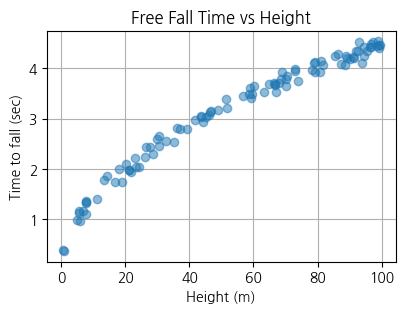

In [28]:
plt.plot(h,t,'o',alpha=0.5)
plt.xlabel('Height (m)')
plt.ylabel('Time to fall (sec)')
plt.title('Free Fall Time vs Height')
plt.grid(True)
plt.show()

그래프를 보면 높이가 높을 수록 낙하시간도 길어지는 경향이 관찰된다. 다만
동일한 높이라 하더라도 낙하시간이 조금씩 차이나는 경우가 있는데, 이는
사람이 시간측정을 수동으로 하며 발생하는 실험오차 때문이다. 이러한
오차에도 불구하고 $h$와 $t$사이에는 일정한 규칙이 존재하는듯 하다.
물리학과 교수님께 자문을 요청한 결과 자유낙하에 걸리는 시간은
$\sqrt{h}$에 비례함을 알 수 있었고 이를 근거로 아래와 같은 모형을
설계하였다.

$$t_i = \beta_0 + \beta_1 \sqrt{h_i}+\epsilon_i, \quad \epsilon_i \sim {\cal N}(0,\sigma^2)$$

위의 모형을 활용하여 높이 $h$로부터 낙하시간 $t$를 예측하는 신경망
모델을 설계하고 학습하라. 학습한 신경망 모델을 활용하여 높이 40m,60m,80m
에서 물체를 자유낙하 시켰을때 지면에 도달하기까지 걸리는 시간을 각각
예측하라.

(풀이)

In [30]:
class FreeFallNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linr = torch.nn.Linear(1,1)
    def forward(self,h):
        netout = self.linr(torch.sqrt(h))
        return netout    

In [31]:
net = FreeFallNet()
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters())
#---#
for epoc in range(10000):
    #1
    netout = net(h)
    #2
    loss = loss_fn(netout,t)
    #3
    loss.backward()
    #4 
    optimizr.step()
    optimizr.zero_grad()

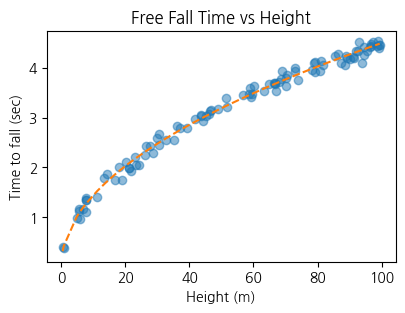

In [32]:
plt.plot(h,t,'o',alpha=0.5)
plt.xlabel('Height (m)')
plt.ylabel('Time to fall (sec)')
plt.title('Free Fall Time vs Height')
plt.plot(h,net(h).data,'--')

In [33]:
hh = torch.tensor([20,30,40,50,60,70]).reshape(6,1)
net(hh)

tensor([[2.0253],
        [2.4746],
        [2.8534],
        [3.1872],
        [3.4889],
        [3.7664]], grad_fn=<AddmmBackward0>)

#### B. MF-based 추천시스템 재설계

`-` 아래의 자료를 활용하여 추천 시스템을 설계하고자 한다.

In [34]:
df_view = pd.read_csv('https://raw.githubusercontent.com/guebin/DL2024/main/posts/solo.csv',index_col=0)
df_view

,영식(IN),영철(IN),영호(IS),광수(IS),상철(EN),영수(EN),규빈(ES),다호(ES)
옥순(IN),NaN,4.02,3.45,3.42,0.84,1.12,0.43,0.49
영자(IN),3.93,3.99,3.63,3.43,0.98,0.96,0.52,NaN
정숙(IS),3.52,3.42,4.05,4.06,0.39,NaN,0.93,0.99
영숙(IS),3.43,3.57,NaN,3.95,0.56,0.52,0.89,0.89
순자(EN),1.12,NaN,0.59,0.43,4.01,4.16,3.52,3.38
현숙(EN),0.94,1.05,0.32,0.45,4.02,3.78,NaN,3.54
서연(ES),0.51,0.56,0.88,0.89,3.50,3.64,4.04,4.10
보람(ES),0.48,0.51,1.03,NaN,3.52,4.00,3.82,NaN
하니(I),4.85,4.82,NaN,4.98,4.53,4.39,4.45,4.52


`-` 사용자 정의 네트워크를 이용하여 MF-based 추천 시스텡을 설계하라ㅣ.

`-` (풀이1) - `net(x1,x2)`

In [36]:
#df_view
class MFbased1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.ebdd1 = torch.nn.Embedding(9,2)
        self.ebdd2 = torch.nn.Embedding(8,2)
        self.b1 = torch.nn.Embedding(9,1)
        self.b2 = torch.nn.Embedding(8,1)        
        self.sig = torch.nn.Sigmoid()
    def forward(self,x1,x2):
        W_features = self.ebdd1(x1) 
        M_features = self.ebdd2(x2) 
        W_bias = self.b1(x1)
        M_bais = self.b2(x2)
        yhat = self.sig((W_features * M_features).sum(axis=1).reshape(-1,1) + W_bias + M_bais)*5        
        return yhat
net = MFbased1()
loss_fn = torch.nn.MSELoss() 
optimizr = torch.optim.Adam(net.parameters())
#----#
for epoc in range(10000):
    #step1
    yhat = net(x1,x2)
    #step2
    loss = loss_fn(yhat,y)
    #step3
    loss.backward()
    #step4
    optimizr.step()
    optimizr.zero_grad()

In [37]:
y[:5], yhat[:5]

(tensor([[4.0200],
         [3.4500],
         [3.4200],
         [0.8400],
         [1.1200]]),
 tensor([[4.0800],
         [3.4664],
         [3.3650],
         [0.9111],
         [0.9538]], grad_fn=<SliceBackward0>))

`-` (풀이2) - `net(X)`

In [38]:
X = torch.stack([x1,x2],axis=1) 

In [39]:
class MFbased2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.ebdd1 = torch.nn.Embedding(9,2)
        self.ebdd2 = torch.nn.Embedding(8,2)
        self.b1 = torch.nn.Embedding(9,1)
        self.b2 = torch.nn.Embedding(8,1)        
        self.sig = torch.nn.Sigmoid()
    def forward(self,X):
        x1 = X[:,0]
        x2 = X[:,1]
        W_features = self.ebdd1(x1) 
        M_features = self.ebdd2(x2) 
        W_bias = self.b1(x1)
        M_bais = self.b2(x2)
        yhat = self.sig((W_features * M_features).sum(axis=1).reshape(-1,1) + W_bias + M_bais)*5        
        return yhat
net = MFbased2()
loss_fn = torch.nn.MSELoss() 
optimizr = torch.optim.Adam(net.parameters())
#----#
for epoc in range(10000):
    #step1
    yhat = net(X)
    #step2
    loss = loss_fn(yhat,y)
    #step3
    loss.backward()
    #step4
    optimizr.step()
    optimizr.zero_grad()

In [40]:
y[:5], yhat[:5]

(tensor([[4.0200],
         [3.4500],
         [3.4200],
         [0.8400],
         [1.1200]]),
 tensor([[4.0802],
         [3.4664],
         [3.3653],
         [0.9109],
         [0.9541]], grad_fn=<SliceBackward0>))

### 4. MF-based 추천시스텡을 넘어서

#### A. NN-based 방식

`-` 아래의 자료를 활용하여 추천시스템을 설계하고자 한다.

In [41]:
df_view = pd.read_csv('https://raw.githubusercontent.com/guebin/DL2025/main/posts/iamsolo.csv',index_col=0)
df_view

,영식(IN),영철(IN),영호(IS),광수(IS),상철(EN),영수(EN),규빈(ES),다호(ES)
옥순(IN),NaN,4.02,3.45,3.42,0.84,1.12,0.43,0.49
영자(IN),3.93,3.99,3.63,3.43,0.98,0.96,0.52,NaN
정숙(IS),3.52,3.42,4.05,4.06,0.39,NaN,0.93,0.99
영숙(IS),3.43,3.57,NaN,3.95,0.56,0.52,0.89,0.89
순자(EN),1.12,NaN,0.59,0.43,4.01,4.16,3.52,3.38
현숙(EN),0.94,1.05,0.32,0.45,4.02,3.78,NaN,3.54
서연(ES),0.51,0.56,0.88,0.89,3.50,3.64,4.04,4.10
보람(ES),0.48,0.51,1.03,NaN,3.52,4.00,3.82,NaN
하니(I),4.85,4.82,NaN,4.98,4.53,4.39,4.45,4.52


In [42]:
#df_view
df_train = df_view.stack().reset_index().set_axis(['여성출연자','남성출연자','궁합점수'],axis=1)
여성인덱스 = {'옥순(IN)':0, '영자(IN)':1, '정숙(IS)':2, '영숙(IS)':3, '순자(EN)':4, '현숙(EN)':5, '서연(ES)':6, '보람(ES)':7, '하니(I)':8}
남성인덱스 = {'영식(IN)':0, '영철(IN)':1, '영호(IS)':2, '광수(IS)':3, '상철(EN)':4, '영수(EN)':5, '규빈(ES)':6, '다호(ES)':7}
x1 = torch.tensor(df_train.여성출연자.map(여성인덱스))
x2 = torch.tensor(df_train.남성출연자.map(남성인덱스))
y = torch.tensor(df_train.궁합점수).reshape(-1,1).float()

`-` NN-based 추천시스템을 설계하라.

`-` (풀이1) - 실패

In [43]:
class NNbased1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #--#
        self.ebdd1 = torch.nn.Embedding(9,2)
        self.ebdd2 = torch.nn.Embedding(8,2)
        self.b1 = torch.nn.Embedding(9,1)
        self.b2 = torch.nn.Embedding(8,1)
        self.sig = torch.nn.Sigmoid()
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(6,1),
            torch.nn.Sigmoid()
        )
    def forward(self,x1,x2):
        W_feature = self.ebdd1(x1)
        W_bias = self.b1(x1)
        M_feature = self.ebdd2(x2)
        M_bias = self.b2(x2)
        #yhat = sig((W_feature * M_feature).sum(axis=1).reshape(-1,1) + W_bias + M_bias ) * 5 
        Z = torch.concat([W_feature, M_feature, W_bias, M_bias],axis=1)
        yhat = self.mlp(Z) * 5 
        return yhat

In [44]:
net = NNbased1()
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters(),lr=0.1) # 이게 편해요!!
#--# 
for epoc in range(5000):
    # 1
    yhat = net(x1,x2) 
    # 2
    loss = loss_fn(yhat,y)
    # 3 
    loss.backward()
    # 4 
    optimizr.step()
    optimizr.zero_grad()

In [45]:
yhat[:5], y[:5]

(tensor([[2.1512],
         [1.6313],
         [2.0479],
         [1.9033],
         [2.3079]], grad_fn=<SliceBackward0>),
 tensor([[4.0200],
         [3.4500],
         [3.4200],
         [0.8400],
         [1.1200]]))

`-` (풀이2) - 모르겠다..그냥 깊은 신경망

In [46]:
class NNbased2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #--#
        self.ebdd1 = torch.nn.Embedding(9,2)
        self.ebdd2 = torch.nn.Embedding(8,2)
        self.b1 = torch.nn.Embedding(9,1)
        self.b2 = torch.nn.Embedding(8,1)
        self.sig = torch.nn.Sigmoid()
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(6,15),
            torch.nn.ReLU(),
            torch.nn.Linear(15,1),
            torch.nn.Sigmoid()
        )
    def forward(self,x1,x2):
        W_feature = self.ebdd1(x1)
        W_bias = self.b1(x1)
        M_feature = self.ebdd2(x2)
        M_bias = self.b2(x2)
        #yhat = sig((W_feature * M_feature).sum(axis=1).reshape(-1,1) + W_bias + M_bias ) * 5 
        Z = torch.concat([W_feature, M_feature, W_bias, M_bias],axis=1)
        yhat = self.mlp(Z) * 5 
        return yhat

In [48]:
net = NNbased2()
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters(),lr=0.1)
#--# 
for epoc in range(3000):
    # 1
    yhat = net(x1,x2) 
    # 2
    loss = loss_fn(yhat,y)
    # 3 
    loss.backward()
    # 4 
    optimizr.step()
    optimizr.zero_grad()

In [49]:
yhat[:10], y[:10]

(tensor([[3.9680],
         [3.3709],
         [3.3554],
         [0.8289],
         [1.0926],
         [0.4222],
         [0.4800],
         [3.8769],
         [3.9545],
         [3.5631]], grad_fn=<SliceBackward0>),
 tensor([[4.0200],
         [3.4500],
         [3.4200],
         [0.8400],
         [1.1200],
         [0.4300],
         [0.4900],
         [3.9300],
         [3.9900],
         [3.6300]]))

`-` *(옥순-영식), (영자-다호), (하니-영호) 를 예측해보자.*

In [50]:
df_view

,영식(IN),영철(IN),영호(IS),광수(IS),상철(EN),영수(EN),규빈(ES),다호(ES)
옥순(IN),NaN,4.02,3.45,3.42,0.84,1.12,0.43,0.49
영자(IN),3.93,3.99,3.63,3.43,0.98,0.96,0.52,NaN
정숙(IS),3.52,3.42,4.05,4.06,0.39,NaN,0.93,0.99
영숙(IS),3.43,3.57,NaN,3.95,0.56,0.52,0.89,0.89
순자(EN),1.12,NaN,0.59,0.43,4.01,4.16,3.52,3.38
현숙(EN),0.94,1.05,0.32,0.45,4.02,3.78,NaN,3.54
서연(ES),0.51,0.56,0.88,0.89,3.50,3.64,4.04,4.10
보람(ES),0.48,0.51,1.03,NaN,3.52,4.00,3.82,NaN
하니(I),4.85,4.82,NaN,4.98,4.53,4.39,4.45,4.52


In [52]:
xx1 = torch.tensor([0,1,8])
xx2 = torch.tensor([0,7,2])

In [53]:
net(xx1,xx2)

tensor([[4.0041],
        [0.6030],
        [4.9861]], grad_fn=<MulBackward0>)

#### B. NCF (He et al. 2017)

`-` MF-based와 NN-base를 합친것

![](https://github.com/guebin/DL2024/blob/main/posts/NCF.png?raw=true)

#### Appendix – 선택학습

`-` 의문 : 그냥 원핫인코딩없이 바로 선형변환하면 안되나? (= 꼭
임베딩레이어를 써야하나?)

In [54]:
x = torch.tensor([0,1,2,0,1])
X = x.reshape(-1,1).float()
x,X

(tensor([0, 1, 2, 0, 1]),
 tensor([[0.],
         [1.],
         [2.],
         [0.],
         [1.]]))

In [55]:
torch.manual_seed(43052)
l1 = torch.nn.Linear(1,1)
l1(X)

tensor([[-0.8470],
        [-1.1937],
        [-1.5404],
        [-0.8470],
        [-1.1937]], grad_fn=<AddmmBackward0>)

In [56]:
torch.manual_seed(43052)
ebdd = torch.nn.Embedding(3,1) 
ebdd(x)

tensor([[-0.8178],
        [-0.7052],
        [-0.5843],
        [-0.8178],
        [-0.7052]], grad_fn=<EmbeddingBackward0>)

`-` 결과적으로 0,1,2 를 다른숫자들로 맵핑한건 비슷해 보임

`-` 수식의 차이: 비슷해보이지만 계산방식이 조금 다름

In [57]:
l1.weight, l1.bias

(Parameter containing:
 tensor([[-0.3467]], requires_grad=True),
 Parameter containing:
 tensor([-0.8470], requires_grad=True))

-   $l_1({\bf X}) = \begin{bmatrix} 0 \\ 1 \\ 2 \\ 0 \\ 1 \end{bmatrix} \times (-0.3467) + (-0.8470)=\begin{bmatrix} -0.8470 \\ -1.1937 \\ -1.5404 \\ -0.8470 \\ -1.1937 \end{bmatrix}$

-   $\text{ebdd}({\boldsymbol x})= \text{linr}\big(\text{onehot}({\boldsymbol x})\big) = \begin{bmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \\ 1 & 0 & 0 \\ 0 & 1 & 0 \end{bmatrix}\begin{bmatrix} -0.8178 \\ -0.7052 \\ -0.5843 \end{bmatrix} = \begin{bmatrix} -0.8178 \\ -0.7052 \\ -0.5843 \\ -0.8178 \\ -0.7052 \end{bmatrix}$

`-` 데이터를 읽으며 해석: 사실상 0,1,2에 대한 의미는
“옥순”,“영숙”,“하니” 같은 자료였고, 임베딩의 결과는
“옥순”,“영숙”,“하니”가 가지는 어떠한 특징이었음 (예를들면 매력같은).
데이터를 상상하며 위의 결과를 다시 해석해보자.

**옥순이 가지는 어떠한 특징 (-0.8470 혹은 -0.8178) 을 바꾸고 싶다면?**

-   `ebdd`의 경우: `ebdd.weigth`에 있는 -0.8178 이라는 숫자를 조정하면
    된다. 이 조정은 옥순의 특징만 바꾸며 영숙과 하니의 특징은 바꾸지
    않는다. (개별조정이 쉬움)
-   `linr`의 경우: `linr.weight`에 있는 -0.3467 혹은 `linr.bias`에 있는
    -0.8470 을 조정하면 되는데, 이를 조정하면 옥순의 특징을 바꿈과
    동시에 영숙/하니의 특징까지 같이 바뀌게 된다. (개별조정이 어려움)

**만약에 출연자가 1000명이라면??**

-   `linr`의 경우: 1000명의 특징을 단 2개의 파라메터로 조정해야한다.
    (그리고 한명의 특징을 바꾸면 999명의 특징이 같이 바뀐다, 개별조정은
    애초에 가능하지 않음.)
-   `ebdd`의 경우: 1000개의 특징을 조정할 수 있는 1000개의 파라메터를
    확보할 수 있게 된다.

`-` 결론: ebdd가 더 파라메터 미세조정을 통하여 특징을 학습하기 용이하다.
(독립적으로 특징값을 줄 수 있으니까!)

> 만약에 문자열이 “최우수(A)”, “우수(B)”, “보통(C)”, “미흡(D)”,
> “매우미흡(F)” 이었다면 특징을 뽑아낼때 linr 가 더 적절했겠죠?

He, Xiangnan, Lizi Liao, Hanwang Zhang, Liqiang Nie, Xia Hu, and
Tat-Seng Chua. 2017. “Neural Collaborative Filtering.” In *Proceedings
of the 26th International Conference on World Wide Web*, 173–82.